# Machine Learning for Forecasting

* A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. 
* The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

## 1. Data loading

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [ ]:
data.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


## 2. Exploratory Data Analysis


In [ ]:
# Change corresponding column to DateTime type and set it as index to make use of pandas' datetime funcionalities.
data.Time = pd.to_datetime(data.Time)

In [ ]:
df = data.set_index('Time')
df = df.asfreq('30min')
df = df.sort_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00+00:00 to 2014-12-31 12:30:00+00:00
Freq: 30T
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Date         52608 non-null  object 
 3   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 1.7+ MB


In [ ]:
df.head()

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00+00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00+00:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00+00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00+00:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00+00:00,4036.229746,20.40,2012-01-01,True


In [ ]:
# Verify if the series is complete
(df.index == pd.date_range(start=df.index.min(),end=df.index.max(),freq=df.index.freq)).all()

True

In [ ]:
print(f"Number of rows with missing values: {df.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [ ]:
# If we want to predict values at a different frequency, 
# we must resample the data to the desired frecuency. For example, from 30min to 1 day per observation
df.drop(columns=['Date'], inplace=True)
df = df.resample(rule='H', closed='left', label ='right').mean() 
df

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00+00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00+00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00+00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00+00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00+00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00+00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00+00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00+00:00,3900.600901,19.650,0.0


* Why do we use the mean operator to aggregate the data?

In [ ]:
# Spliting data
df = df.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}")

Train dates      : 2012-01-01 00:00:00+00:00 --- 2013-12-31 23:00:00+00:00
Validation dates : 2014-01-01 00:00:00+00:00 --- 2014-11-30 23:00:00+00:00
Test dates       : 2014-12-01 00:00:00+00:00 --- 2014-12-30 23:00:00+00:00


When it is necessary to generate a forecasting model, plotting the time series values could be useful. This allows identifying patterns such as trends and seasonality.

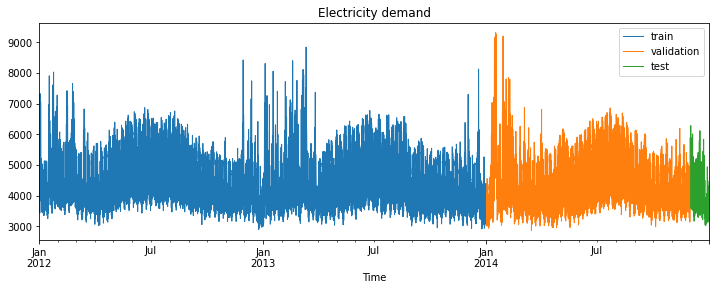

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
df_train.Demand.plot(ax=ax, label='train', linewidth=1)
df_val.Demand.plot(ax=ax, label='validation', linewidth=1)
df_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

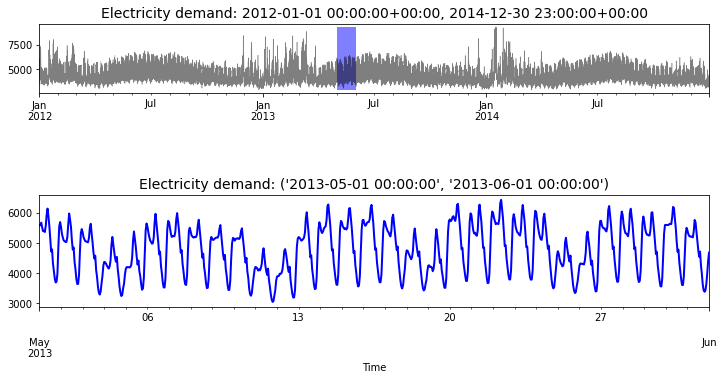

In [ ]:
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 00:00:00','2013-06-01 00:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

df.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(df.Demand)
max_y = max(df.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

df.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {df.index.min()}, {df.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


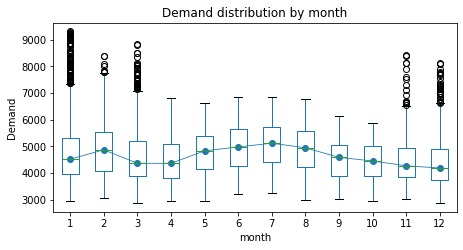

In [ ]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df['month'] = df.index.month
df.boxplot(column='Demand', by='month', ax=ax,)
df.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


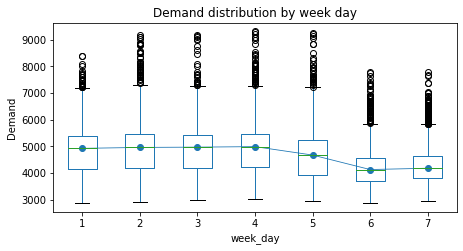

In [ ]:
# Boxplot for weekly seasonality (1=monday, 7=sunday)
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='Demand', by='week_day', ax=ax)
df.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

In [ ]:
df

,Demand,Temperature,Holiday,month,week_day
Time,,,,,
2012-01-01 00:00:00+00:00,4329.049863,27.000,1.0,1,7
2012-01-01 01:00:00+00:00,4685.820480,29.650,1.0,1,7
2012-01-01 02:00:00+00:00,5009.466997,31.650,1.0,1,7
2012-01-01 03:00:00+00:00,5270.116328,32.675,1.0,1,7
2012-01-01 04:00:00+00:00,5487.388289,32.300,1.0,1,7
...,...,...,...,...,...
2014-12-30 19:00:00+00:00,3307.042391,13.000,0.0,12,2
2014-12-30 20:00:00+00:00,3527.232855,12.100,0.0,12,2
2014-12-30 21:00:00+00:00,3846.439766,12.300,0.0,12,2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


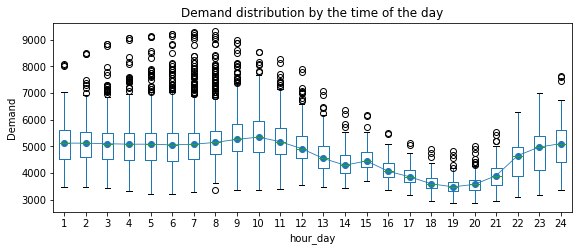

In [ ]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
df['hour_day'] = df.index.hour + 1
df.boxplot(column='Demand', by='hour_day', ax=ax)
df.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');

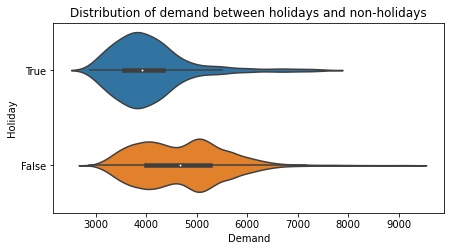

In [ ]:
# Violinplot for holydays
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = data.assign(Holiday = data.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday');

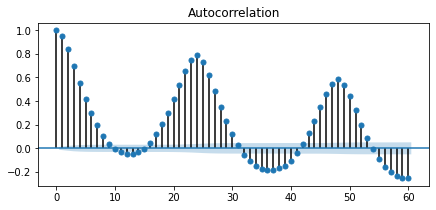

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df.Demand, ax=ax, lags=60)
plt.show()

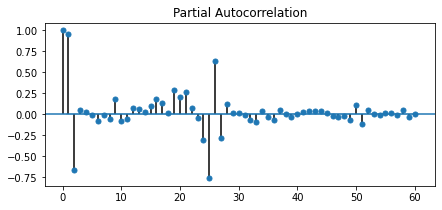

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df.Demand, ax=ax, lags=60)
plt.show()

The autocorrelation and partial autocorrelation plots show a clear association between one hour's demand and previous hours, as well as between one hour's demand and the same hour's demand on previous days. This type of correlation is an indication that autoregressive models can work well.

__Which patterns did you find in the exploratory analysis?__

## 3. Training autoregressive models

A recursive autoregressive model is created and trained with a time window of 24 lags. The latter means that, for each prediction, the demand values of the previous 24 hours are used as predictors.

In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.9 MB/s 
     |████████████████████████████████| 9.8 MB 15.0 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [ ]:
# Spliting data
df = df.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}")

Train dates      : 2012-01-01 00:00:00+00:00 --- 2013-12-31 23:00:00+00:00
Validation dates : 2014-01-01 00:00:00+00:00 --- 2014-11-30 23:00:00+00:00
Test dates       : 2014-12-01 00:00:00+00:00 --- 2014-12-30 23:00:00+00:00


In [ ]:
forecaster = ForecasterAutoreg(regressor = make_pipeline(StandardScaler(), Ridge()),lags = 24)
#forecaster = ForecasterAutoreg(regressor = make_pipeline(StandardScaler(), DecisionTreeRegressor()),lags = 24)
forecaster.fit(y=df_train.loc[:, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2013-12-31 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-05-30 14:51:18 
Last fit date: 2022-05-30 14:51:18 
Skforecast version: 0.4.3 

In [ ]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Demand,
                            initial_train_size = len(df.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                       )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00
    Validation: 2014-12-01 00:00:00+00:00 -- 2014-12-01 23:00:00+00:00
Data partition in fold: 1
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00
    Validation: 2014-12-02 00:00:00+00:00 -- 2014-12-02 23:00:00+00:00
Data partition in fold: 2
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00
    Validation: 2014-12-03 00:00:00+00:00 -- 2014-12-03 23:00:00+00:00
Data partition in fold: 3
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00
    Validation: 2014-12-04 00:00:00+00:00 -- 2014-12-04 23:00:00+00:00
Data partition in fold: 4
    Training:   2012-01-01 00:00:00+00:00 -- 201

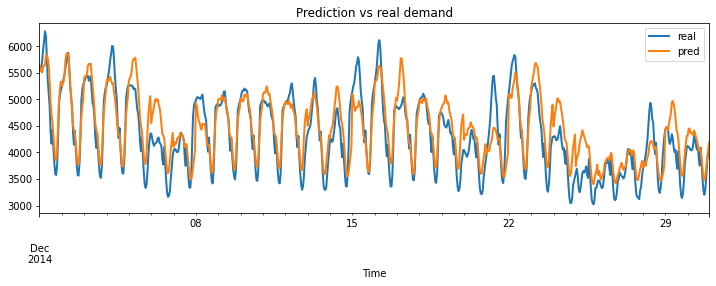

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions.index, 'Demand'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [ ]:
print(f'Backtest error: {metric}')

Backtest error: 289.5191503038135


### Hyperparameter tuning using Grid Search

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]] # 5 = last 5 hours, 24 = last 24 hours, [1,2,3,..,48,49] = those particular hours

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df.loc[:end_validation, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(df[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                 )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:16<00:00, 25.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'ridge__alpha': 215.44346900318823}
  Backtesting metric: 257.8431725056731



In [ ]:
results_grid

,lags,params,metric,ridge__alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 215.44346900318823},257.843173,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 27.825594022071257},290.555205,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 3.593813663804626},306.631981,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.46415888336127775},309.393349,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.05994842503189409},309.776084,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.007742636826811269},309.825962,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.001},309.832410,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},325.041129,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},325.043579,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},325.062536,0.059948


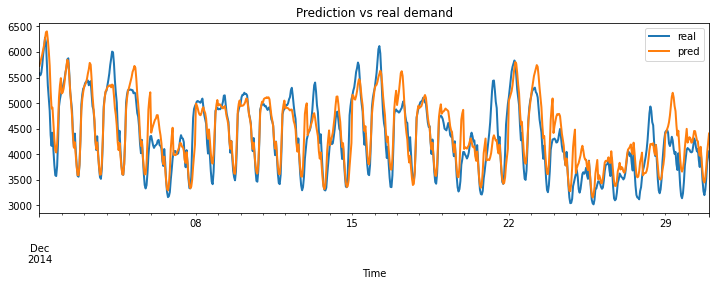

In [ ]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Demand,
                            initial_train_size = len(df[:end_validation]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

## Training with exogenous factors

In the previous example, only lags of the predicted variable itself have been used as predictors. In some scenarios, it is possible to have information about other variables, whose future value is known, and which can serve as additional predictors in the model. Example:

* Holidays (local, national...)

* Month of the year

* Day of the week

* Time of day

In [ ]:
# The Holiday column is converted from boolean to integer
df.loc[:,'Holiday'] = df['Holiday'].astype(int)
df_train.loc[:,'Holiday'] = df_train['Holiday'].astype(int)
df_test.loc[:,'Holiday'] = df_test['Holiday'].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(regressor = make_pipeline(StandardScaler(), Ridge(alpha=215.44)),lags = [1, 2, 3, 23, 24, 25, 47, 48, 49])

forecaster.fit(y=df.Demand[:end_validation], exog=df.Holiday[:end_validation])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=215.44))]) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Window size: 49 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-30 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 215.44, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-05-30 14:52:37 
Last fit date: 2022-05-30 14:52:37 
Skforecast version: 0.4.3 

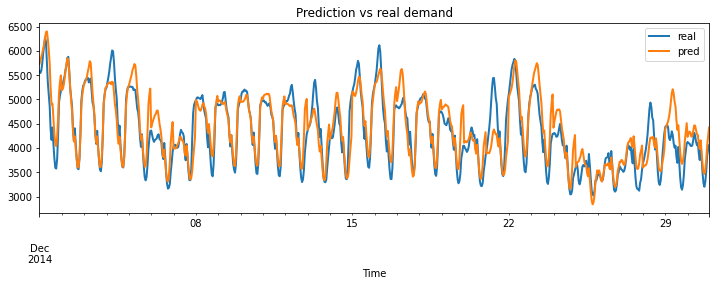

In [ ]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Demand,
                            initial_train_size = len(df[:end_validation]),
                            exog = df.Holiday,
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [ ]:
print(f'Backtest error: {metric}')

Backtest error: 246.99883418726822


In [ ]:
# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
df.loc[:,'Holiday_day_before'] = df['Holiday'].shift(24)
df.loc[:,'Holiday_next_day']   = df['Holiday'].shift(-24)
df = df.dropna()

# One hot encoding of week_day and hour_day
df = pd.get_dummies(df, columns=['week_day', 'hour_day'])
df.head(3)

,Demand,Temperature,Holiday,month,Holiday_day_before,Holiday_next_day,week_day_1,week_day_2,week_day_3,week_day_4,...,hour_day_15,hour_day_16,hour_day_17,hour_day_18,hour_day_19,hour_day_20,hour_day_21,hour_day_22,hour_day_23,hour_day_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00+00:00,5262.895338,32.825,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 01:00:00+00:00,5786.043417,34.500,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 02:00:00+00:00,6236.144167,36.725,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=215.44)),
                lags      = [1, 2, 3, 23, 24, 25, 47, 48, 49],
             )

exog = [column for column in df.columns if column.startswith(('week_day', 'hour', 'Holiday'))]
forecaster.fit(y=df.Demand[: end_validation], exog=df[exog][: end_validation])


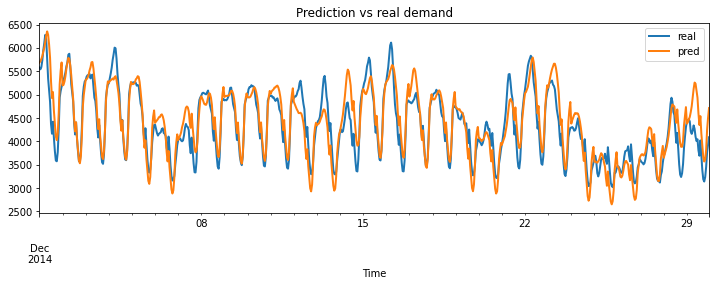

In [ ]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Demand,
                            initial_train_size = len(df[:end_validation]),
                            exog = df.loc[:,exog],
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [ ]:
print(f'Backtest error: {metric}')

Backtest error: 252.69202817507076


## Training a multi-step model

The Autoregressive models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results.

In [39]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df.loc[:end_validation, 'Demand'],
                        exog        = df.loc[:end_validation, exog],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(df.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 8


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [03:42<00:00, 111.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 237.27478811428122



In [40]:
results_grid

,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 500}",237.274788,6,500
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",238.431847,6,500
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 500}",244.284279,4,500
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",247.039643,4,500
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 100}",262.574141,6,100
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",265.343694,6,100
4,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 100}",295.452096,4,100
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",299.078182,4,100


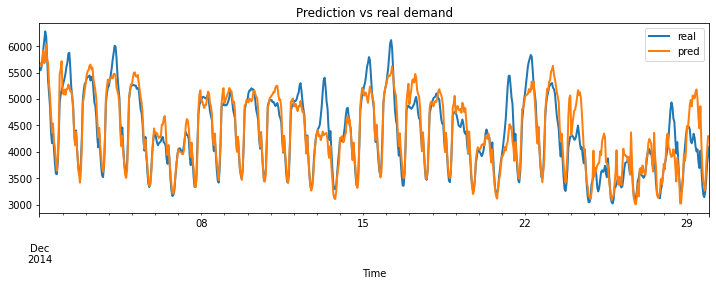

In [41]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Demand,
                            initial_train_size = len(df[:end_validation]),
                            exog = df.loc[:,exog],
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [42]:
error = mean_absolute_error(
            y_true = df.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 207.24522450366942


# References

* https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html
* https://joaquinamatrodrigo.github.io/skforecast/0.4.3/api/ForecasterAutoreg.html
* https://www.datapred.com/blog/the-basics-of-backtesting
* https://interactivechaos.com/es/manual/tutorial-de-machine-learning/elastic-net

